# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [44]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [45]:
transcript.head(5)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [46]:
transcript.tail(5)

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [47]:
profile.head(5)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [48]:
portfolio.head(5)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## Data Cleaning

Customer ID column is given different name in these sets renaming them to maintain consistency

In [49]:
portfolio.rename({'id': 'offer_id'}, axis = 1, inplace = True)
transcript.rename({'person': 'customer_id'}, axis = 1, inplace = True)
profile.rename({'id': 'customer_id'}, axis = 1, inplace = True)

In [50]:
portfolio["channels"].value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[web, email, mobile, social]    4
[web, email, mobile]            3
[email, mobile, social]         2
[web, email]                    1
Name: channels, dtype: int64

The offer can be notified to the customer in four different channels.Creating dummy variables for respective channels.

So there are totaly 10 offers, 4 Buy One Get One,4 discount and 2 informational offers.

In [51]:
#Creating dummy variables for channels
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social'in x else 0)
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
#we dont need channels anymore
portfolio.drop("channels",inplace=True,axis=1)

In [52]:
portfolio["offer_type"].value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

So there are totaly 10 offers, 4 Buy One Get One,4 discount and 2 informational offers.

In [53]:
#Creating dummy variables for offer_type
portfolio["bogo"]=portfolio["offer_type"].apply(lambda x: 1 if "bogo" in x else 0)
portfolio["informational"]=portfolio["offer_type"].apply(lambda x: 1 if "informational" in x else 0)
portfolio["discount"]=portfolio["offer_type"].apply(lambda x: 1 if "discount" in x else 0)
portfolio.drop("offer_type",inplace=True,axis=1)                                                      

In [54]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [55]:
offer_received = transcript[transcript['event'] == 'offer received']
offer_viewed =transcript[transcript['event'] == 'offer viewed']
offer_completed  =transcript[transcript['event'] == 'offer completed']
transaction =transcript[transcript['event'] == 'transaction']

Created seperate Dataframes to find the combination of values present in event column.

In [56]:
offer_received['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    7677
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    7668
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    7658
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7646
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    7632
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    7618
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    7617
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7597
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7593
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7571
Name: value, dtype: int64

In [57]:
offer_viewed['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    7337
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    7327
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    7298
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    7264
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    6716
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}    6687
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}    4171
{'offer id': '3f207df678b143eea3cee63160fa8bed'}    4144
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}    4118
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}    2663
Name: value, dtype: int64

In [58]:
offer_completed['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}     5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}     5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}     4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}     4296
{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}     4017
{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}    3688
{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'reward': 5}     3420
{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}    3331
Name: value, dtype: int64

In [59]:
transaction['value'].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'amount': 0.05}      431
{'amount': 0.66}      166
{'amount': 1.18}      165
{'amount': 1.01}      163
{'amount': 1.23}      161
                     ... 
{'amount': 42.31}       1
{'amount': 44.62}       1
{'amount': 42.27}       1
{'amount': 108.89}      1
{'amount': 476.33}      1
Name: value, Length: 5103, dtype: int64

Fill with the combination values latter on

In [60]:
def offer_mapper(data):
    '''
     
    '''
    
    if 'offer id' in data:
        return data['offer id']
    elif 'offer_id' in data:
        return data['offer_id']

In [61]:
def id_mapper(df,column_name):
    '''
    
    '''
    dict_=dict()
    index=1
    
    for val in df[column_name]:
        if val not in dict_:
            dict_[val]=index
            index=index+1
    
    return dict_

In [62]:
ids_dict=id_mapper(profile,'customer_id')
offer_ids_dict=id_mapper(portfolio,'offer_id')


In [63]:
def reward_mapper(data):
    '''
    
    '''
    
    if 'reward' in data:
        #print("{} is being returned for {}".format(data['reward'],data))
        return data['reward']
    else:
        return 0

In [64]:
offer_activity = transcript[transcript['event'] != 'transaction' ]
transactions = transcript[transcript['event'] == 'transaction' ]
offer_dict = id_mapper(portfolio, 'offer_id')
# map offer activity with set IDs and reward amounts
offer_activity.loc[:, 'offer_id'] = offer_activity['value'].apply(offer_mapper)
offer_activity.loc[:, 'reward'] = offer_activity['value'].apply(reward_mapper)
offer_activity.loc[:, 'offer_id'] = offer_activity['offer_id'].map(offer_dict)
offer_activity['customer_id']=offer_activity['customer_id'].map(ids_dict)
offer_activity.drop('value',axis=1,inplace=True)


In [65]:
offer_activity.head(5)

,customer_id,event,time,offer_id,reward
0,4,offer received,0,4,0
1,5,offer received,0,5,0
2,6,offer received,0,10,0
3,7,offer received,0,7,0
4,8,offer received,0,2,0


In [66]:
transactions['customer_id']=transactions['customer_id'].map(ids_dict)
transactions['amount'] = transactions['value'].apply(lambda x: x['amount'])
transactions.drop('value', inplace = True, axis = 1)
transactions

,customer_id,event,time,amount
12654,42,transaction,0,0.83
12657,56,transaction,0,34.56
12659,64,transaction,0,13.23
12670,135,transaction,0,19.51
12671,152,transaction,0,18.97
...,...,...,...,...
306529,16960,transaction,714,1.59
306530,16965,transaction,714,9.53
306531,16980,transaction,714,3.61
306532,16988,transaction,714,3.53


In [67]:
transactions.head(5)

,customer_id,event,time,amount
12654,42,transaction,0,0.83
12657,56,transaction,0,34.56
12659,64,transaction,0,13.23
12670,135,transaction,0,19.51
12671,152,transaction,0,18.97


In [68]:
portfolio['offer_id']=portfolio['offer_id'].map(offer_ids_dict)
#duration (int) in portfolio - time for offer to be open, in days and time (int) in transcript- time in hours since start of test.
#converting duration(int) to hours to be on the same page
portfolio['duration']=portfolio['duration'].apply(lambda x:x*24)
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,informational,discount
0,10,10,168,1,1,1,1,0,1,0,0
1,10,10,120,2,1,1,1,1,1,0,0
2,0,0,96,3,1,1,0,1,0,1,0
3,5,5,168,4,1,1,0,1,1,0,0
4,5,20,240,5,1,0,0,1,0,0,1
5,3,7,168,6,1,1,1,1,0,0,1
6,2,10,240,7,1,1,1,1,0,0,1
7,0,0,72,8,1,1,1,0,0,1,0
8,5,5,120,9,1,1,1,1,1,0,0
9,2,10,168,10,1,1,0,1,0,0,1


In [69]:
portfolio.head(5)

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,informational,discount
0,10,10,168,1,1,1,1,0,1,0,0
1,10,10,120,2,1,1,1,1,1,0,0
2,0,0,96,3,1,1,0,1,0,1,0
3,5,5,168,4,1,1,0,1,1,0,0
4,5,20,240,5,1,0,0,1,0,0,1


In [70]:
profile['customer_id']=profile['customer_id'].map(ids_dict)
profile

,gender,age,customer_id,became_member_on,income
0,None,118,1,20170212,NaN
1,F,55,2,20170715,112000.0
2,None,118,3,20180712,NaN
3,F,75,4,20170509,100000.0
4,None,118,5,20170804,NaN
...,...,...,...,...,...
16995,F,45,16996,20180604,54000.0
16996,M,61,16997,20180713,72000.0
16997,M,49,16998,20170126,73000.0
16998,F,83,16999,20160307,50000.0


In [71]:
profile.head(5)

,gender,age,customer_id,became_member_on,income
0,None,118,1,20170212,NaN
1,F,55,2,20170715,112000.0
2,None,118,3,20180712,NaN
3,F,75,4,20170509,100000.0
4,None,118,5,20170804,NaN


In [72]:
#Extracting customer id's and offer id's for future use
customer_ids=list(x for x in ids_dict.values())
offer_ids=list(x for x in offer_ids_dict.values())

### Checking for skewed data

### Profile

In [73]:
profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')

In [74]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [75]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['year_joined'] = profile['became_member_on'].dt.year
profile.drop('became_member_on',axis=1,inplace=True)

Starbucks was founded by Jerry Baldwin, Gordon Bowker, and Zev Siegl, opening its first store in 1971.So 'Year joined' Column cannot have a value less than 1971

In [76]:
import datetime
profile['year_joined']=profile['year_joined'].apply(lambda x:None if x<1971 else x)
profile['year_joined']=profile['year_joined'].apply(lambda x:None if x>datetime.datetime.now().year else x)

In [77]:
profile.isna().sum()

gender         2175
age               0
customer_id       0
income         2175
year_joined       0
dtype: int64

In [78]:
profile[profile['gender'].isna()]


,gender,age,customer_id,income,year_joined
0,None,118,1,NaN,2017
2,None,118,3,NaN,2018
4,None,118,5,NaN,2017
6,None,118,7,NaN,2017
7,None,118,8,NaN,2017
...,...,...,...,...,...
16980,None,118,16981,NaN,2016
16982,None,118,16983,NaN,2016
16989,None,118,16990,NaN,2018
16991,None,118,16992,NaN,2016


2175 entires have missing values in gender and it also looks like for every NaN value of gender there is a NaN value in income and the age is 118.

In [79]:
profile[(profile[['gender','income']].isnull().all(1)) & (profile['age']==118)]

,gender,age,customer_id,income,year_joined
0,None,118,1,NaN,2017
2,None,118,3,NaN,2018
4,None,118,5,NaN,2017
6,None,118,7,NaN,2017
7,None,118,8,NaN,2017
...,...,...,...,...,...
16980,None,118,16981,NaN,2016
16982,None,118,16983,NaN,2016
16989,None,118,16990,NaN,2018
16991,None,118,16992,NaN,2016


In [80]:
all_null_values_df=profile[profile['gender'].isna()]
age_118_and_both_col_nullvalues=profile[(profile[['gender','income']].isnull().all(1)) & (profile['age']==118)]

In [81]:
all_null_values_df.equals(age_118_and_both_col_nullvalues)

True

So there are 2175 rows with null values in both 'gender' and 'income' with age as 118.Its better to remove these rows instead of filling the NaN's with any of the filling methods.

In [82]:
profile.dropna(inplace=True)

In [83]:
profile['age'].mean()

54.39352445193929

In [84]:
profile['income'].mean()

65404.9915682968

In [85]:
print(profile['income'].max())
print(profile['income'].min())

120000.0
30000.0


Everything with income looks fine

In [86]:
profile.isna().sum()

gender         0
age            0
customer_id    0
income         0
year_joined    0
dtype: int64

Customerd ID's that got dropped from profile should also be dropped from transactions dataframe

In [87]:
customer_ids=profile['customer_id'].to_list()

In [88]:
profile=profile[['customer_id','age','gender','income','year_joined']]

In [89]:
profile

,customer_id,age,gender,income,year_joined
1,2,55,F,112000.0,2017
3,4,75,F,100000.0,2017
5,6,68,M,70000.0,2018
8,9,65,M,53000.0,2018
12,13,58,M,51000.0,2017
...,...,...,...,...,...
16995,16996,45,F,54000.0,2018
16996,16997,61,M,72000.0,2018
16997,16998,49,M,73000.0,2017
16998,16999,83,F,50000.0,2016


### ask hurucan regarding this dominated filled mean values being in more number than valid values.

### Portfolio

In [90]:
portfolio.columns

Index(['reward', 'difficulty', 'duration', 'offer_id', 'email', 'mobile',
       'social', 'web', 'bogo', 'informational', 'discount'],
      dtype='object')

In [91]:

print("The min reward for a offer is:",portfolio['reward'].min())
print("The max reward for a offer is:",portfolio['reward'].max())
print("The min difficulty for a offer is:",portfolio['difficulty'].min())
print("The max difficulty for a offer is:",portfolio['difficulty'].max())
print("The min duration for a offer in hours is:",portfolio['duration'].min())
print("The max duration for a offer in hours is:",portfolio['duration'].max())

The min reward for a offer is: 0
The max reward for a offer is: 10
The min difficulty for a offer is: 0
The max difficulty for a offer is: 20
The min duration for a offer in hours is: 72
The max duration for a offer in hours is: 240


A offer cannot be BOGO,informational and discount at the same time.If the offer belongs to a particular category it cannot belong any other

In [92]:
sum((portfolio[['bogo','informational','discount']].sum(axis=1)>1))

0

In [93]:
portfolio.isna().sum()

reward           0
difficulty       0
duration         0
offer_id         0
email            0
mobile           0
social           0
web              0
bogo             0
informational    0
discount         0
dtype: int64

In [94]:
#rearranging columns
portfolio=portfolio[['offer_id','reward', 'difficulty', 'duration','email', 'mobile',
       'social', 'web', 'bogo', 'informational', 'discount']]

In [95]:
portfolio.to_csv('data/portfolio_cleaned.csv',index=False,mode='w+')

### Transcript

Transcript got divide into two seperate dataframs 'offer_activity' with all the events related to offers and 'transactions' related to all the transactions done by the customers.
#### offer_activity

In [96]:
offer_activity.columns

Index(['customer_id', 'event', 'time', 'offer_id', 'reward'], dtype='object')

In [97]:
offer_activity=offer_activity[offer_activity['customer_id'].isin(customer_ids)]

In [98]:
offer_activity['event'].value_counts()

offer received     66501
offer viewed       49860
offer completed    32444
Name: event, dtype: int64

In [99]:
print("The min time",offer_activity['time'].min())
print("The max time",offer_activity['time'].max())
print("The min reward",offer_activity['reward'].min())
print("The max time",offer_activity['reward'].max())



The min time 0
The max time 714
The min reward 0
The max time 10


In [100]:
offer_activity.isna().sum()

customer_id    0
event          0
time           0
offer_id       0
reward         0
dtype: int64

In [101]:
offer_activity=offer_activity[['customer_id','offer_id', 'event', 'time','reward']]

The zero value for min time implies the start of the test and min reward implies that it is just a informational offer

### transactions

In [102]:
transactions.columns

Index(['customer_id', 'event', 'time', 'amount'], dtype='object')

In [103]:
transactions=transactions[transactions['customer_id'].isin(customer_ids)]

In [104]:
transactions['event'].value_counts()

transaction    123957
Name: event, dtype: int64

In [105]:
print("The min time",transactions['time'].min())
print("The max time",transactions['time'].max())
print("The min amount",transactions['amount'].min())
print("The max amount",transactions['amount'].max())

The min time 0
The max time 714
The min amount 0.05
The max amount 1062.28


In [106]:
transactions['amount'].mean()

13.996324531893954

In [107]:
transactions[transactions['amount']<0.10]

,customer_id,event,time,amount
12967,1899,transaction,0,0.05
15057,14320,transaction,0,0.05
15294,15604,transaction,0,0.08
15765,1432,transaction,6,0.07
16382,5656,transaction,6,0.08
...,...,...,...,...
304216,14935,transaction,702,0.05
304514,2976,transaction,708,0.05
305161,12960,transaction,708,0.05
305938,7909,transaction,714,0.08


No idea for what item the customers paid less than 0.10 dollars but not altering this data.

In [108]:
transactions.isna().sum()

customer_id    0
event          0
time           0
amount         0
dtype: int64

Now there are four cleaned dataframes, Profile,portfolio,offer_activity,transactions

In [109]:
profile.head(5)

,customer_id,age,gender,income,year_joined
1,2,55,F,112000.0,2017
3,4,75,F,100000.0,2017
5,6,68,M,70000.0,2018
8,9,65,M,53000.0,2018
12,13,58,M,51000.0,2017


In [110]:
portfolio.head(10)

,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
0,1,10,10,168,1,1,1,0,1,0,0
1,2,10,10,120,1,1,1,1,1,0,0
2,3,0,0,96,1,1,0,1,0,1,0
3,4,5,5,168,1,1,0,1,1,0,0
4,5,5,20,240,1,0,0,1,0,0,1
5,6,3,7,168,1,1,1,1,0,0,1
6,7,2,10,240,1,1,1,1,0,0,1
7,8,0,0,72,1,1,1,0,0,1,0
8,9,5,5,120,1,1,1,1,1,0,0
9,10,2,10,168,1,1,0,1,0,0,1


In [111]:
offer_activity.head(5)

,customer_id,offer_id,event,time,reward
0,4,4,offer received,0,0
2,6,10,offer received,0,0
5,9,9,offer received,0,0
7,13,3,offer received,0,0
8,14,5,offer received,0,0


In [112]:
offer_activity[offer_activity['customer_id']==60]

,customer_id,offer_id,event,time,reward
53216,60,5,offer received,168,0
110869,60,3,offer received,336,0
150639,60,1,offer received,408,0
174367,60,1,offer viewed,426,0
201609,60,7,offer received,504,0
243237,60,7,offer viewed,570,0


In [113]:
transactions[transactions['customer_id']==60]

,customer_id,event,time,amount
38224,60,transaction,84,2.51
104850,60,transaction,300,4.59
147221,60,transaction,396,6.58
237378,60,transaction,552,0.30
243238,60,transaction,570,0.87
268850,60,transaction,594,2.15


In [114]:
offer_activity.sort_values(by=['customer_id','offer_id'],inplace=True)

In [115]:
offer_activity.head(20)
offer_recieved_times=offer_activity[offer_activity['event']=='offer received'][['customer_id','offer_id','time']]

In [116]:
offer_recieved_times

,customer_id,offer_id,time
201571,2,3,504
150597,2,4,408
150598,4,1,408
0,4,4,0
53176,4,8,168
...,...,...,...
163372,16999,4,408
123538,17000,3,336
257886,17000,3,576
12649,17000,6,0


In [117]:
for i in range(1,11):
    offer_activity['offer_{}_received'.format(i)]=np.where(((offer_activity['offer_id']==i) & (offer_activity['event']=='offer received')),1,0)
    offer_activity['offer_{}_viewed'.format(i)]=np.where(((offer_activity['offer_id']==i) & (offer_activity['event']=='offer viewed')),1,0)
    offer_activity['offer_{}_recievedtime'.format(i)]=np.where(((offer_activity['offer_id']==i) & (offer_activity['event']=='offer received')),offer_activity['time'],0)

In [118]:
offer_activity=offer_activity.reset_index(drop=True)
offer_activity.shape[0]

148805

In [119]:
offer_activity

,customer_id,offer_id,event,time,reward,offer_1_received,offer_1_viewed,offer_1_recievedtime,offer_2_received,offer_2_viewed,...,offer_7_recievedtime,offer_8_received,offer_8_viewed,offer_8_recievedtime,offer_9_received,offer_9_viewed,offer_9_recievedtime,offer_10_received,offer_10_viewed,offer_10_recievedtime
0,2,3,offer received,504,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,4,offer received,408,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,offer completed,528,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,offer received,408,0,1,0,408,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,offer viewed,408,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148800,17000,6,offer viewed,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148801,17000,6,offer completed,54,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148802,17000,9,offer received,408,0,0,0,0,0,0,...,0,0,0,0,1,0,408,0,0,0
148803,17000,9,offer completed,480,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
offer_activity.drop({'offer_id','event','time'},axis=1,inplace=True)

In [121]:
offer_col=offer_activity.columns.tolist()

In [122]:
col=dict()
for i in offer_col:
    col[i]='sum'
del col['customer_id']

In [123]:
offer_activity=offer_activity.groupby(['customer_id'],as_index=False).agg(col)

In [124]:
pd.set_option("display.max_columns", None)
offer_activity.head(5)

,customer_id,reward,offer_1_received,offer_1_viewed,offer_1_recievedtime,offer_2_received,offer_2_viewed,offer_2_recievedtime,offer_3_received,offer_3_viewed,offer_3_recievedtime,offer_4_received,offer_4_viewed,offer_4_recievedtime,offer_5_received,offer_5_viewed,offer_5_recievedtime,offer_6_received,offer_6_viewed,offer_6_recievedtime,offer_7_received,offer_7_viewed,offer_7_recievedtime,offer_8_received,offer_8_viewed,offer_8_recievedtime,offer_9_received,offer_9_viewed,offer_9_recievedtime,offer_10_received,offer_10_viewed,offer_10_recievedtime
0,2,5,0,0,0,0,0,0,1,0,504,1,0,408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,20,1,1,408,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,168,1,1,504,0,0,0
2,6,7,0,0,0,0,0,0,1,0,336,1,1,408,0,0,0,0,0,0,1,1,504,0,0,0,0,0,0,1,1,0
3,9,19,0,0,0,0,0,0,0,0,0,2,2,576,0,0,0,0,0,0,1,1,576,0,0,0,2,2,504,1,1,336
4,13,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,168,1,1,336,0,0,0,0,0,0,0,0,0


In [125]:
def get_recieved_time(cust_id,offer_id,offer_recieved_times,count):
    '''
    Input
    
    Output
    
    '''
    df_recieve_time=offer_recieved_times[(offer_recieved_times['customer_id']==cust_id) & (offer_recieved_times['offer_id']==offer_id)].reset_index()
    recieved_times_list=[]
    for i in range(0,count):
        recieved_times_list.append(df_recieve_time['time'][i])
    return recieved_times_list
        

In [126]:
# print("This is initial case",cases)
# print("This is customer_id",cust_id)
# print("This is offer_id",offer_id)
# print("This is offer_recieved",offer_recieved)
# print("This is offer_recieved_time",offer_recieved_time)
# print("This is offer_viewed",cust_id)
# print("This is offer_duration",offer_duration)
# print("This is amount_to_be_spent",amount_to_be_spent)
# print("This is transcation log",t_df)
# print("This is amount_spent",amount_spent)
# print("This is amount_to_be_spent",amount_to_be_spent)
# print("This is case0",cases[0])
# print("This is case1",cases[1])
# print("This is case2",cases[2])
# print("This is case3",cases[3])



In [127]:
def mainfunction(data,offer_id,portfolio,transactions,offer_recieved_times):
    cases=[0,0,0,0]
    cust_id=data['customer_id']
    offer_id=offer_id
    offer_recieved=data[1]
    if offer_recieved>0:
        if offer_recieved>1:
            count=offer_recieved
            offer_viewed=data[3]
            offer_recieved_time=get_recieved_time(cust_id,offer_id,offer_recieved_times,count)
            offer_duration=int(portfolio[portfolio['offer_id']==offer_id]['duration'])
            amount_to_be_spent=float(portfolio[portfolio['offer_id']==offer_id]['difficulty'])
            for i in range(0,count):
                t_df=transactions[(transactions['customer_id']==cust_id) & (transactions['time']>=offer_recieved_time[i]) & (transactions['time']<=offer_recieved_time[i]+offer_duration)]
                if(t_df.shape[0]!=0):

                    amount_spent=float(t_df.groupby('customer_id').agg({'amount':'sum'})['amount'])
                    if (offer_recieved>=1) & (offer_viewed>=1) & (amount_spent>amount_to_be_spent): #Completed
                        cases[0]=cases[0]+1

                    elif (offer_recieved>=1) & (offer_viewed==0) & (amount_spent>amount_to_be_spent): #accidentally completed
                        cases[1]=cases[1]+1

                    elif (offer_recieved>=1) & (offer_viewed>=1) & (amount_spent<amount_to_be_spent): #ignored
                        cases[2]=cases[2]+1
                elif (offer_recieved>=1) & (offer_viewed>=1) & (t_df.shape[0]==0): #saw the offer but didnot make any transcation during the offer period
                    cases[2]=cases[2]+1
                else:
                    cases[3]=cases[3]+1

                offer_recieved=offer_recieved-1
                offer_viewed=offer_viewed-1


        else:
            #offer_recieved_time=offer_recieved_times[(offer_recieved_times['customer_id']==cust_id) & (offer_recieved_times['offer_id']==offer_id)]
            offer_recieved_time=data[2]
            offer_viewed=data[3]
            offer_duration=int(portfolio[portfolio['offer_id']==offer_id]['duration'])
            amount_to_be_spent=float(portfolio[portfolio['offer_id']==offer_id]['difficulty'])

            t_df=transactions[(transactions['customer_id']==cust_id) & (transactions['time']>=offer_recieved_time) & (transactions['time']<=offer_recieved_time+offer_duration)]
           
            if(t_df.shape[0]!=0):
                amount_spent=float(t_df.groupby('customer_id').agg({'amount':'sum'})['amount'])
                
                if (offer_recieved==1) & (offer_viewed==1) & (amount_spent>amount_to_be_spent): #completed
                    cases[0]=cases[0]+1
                   
                elif (offer_recieved==1) & (offer_viewed==0) & (amount_spent>amount_to_be_spent):#accidentaly completed
                    cases[1]=cases[1]+1
                    
                elif (offer_recieved==1) & (offer_viewed==1) & (amount_spent<amount_to_be_spent): #igonred
                    cases[2]=cases[2]+1
                    

            elif (offer_recieved==1) & (offer_viewed==1) & (t_df.shape[0]==0): #saw the offer but didnot make any transcation during the offer period
                cases[2]=cases[2]+1
            else:
                cases[3]=cases[3]+1
        return cases[0],cases[1],cases[2],data[1]-(cases[0]+cases[1]+cases[2])
    else:
        return cases[0],cases[1],cases[2],cases[3]
    
        
        
    
    
    

In [128]:
for i in range(1,11):
    offer_activity['offer_{}_completed'.format(i)],offer_activity['offer_{}_accidentallycompleted'.format(i)],offer_activity['offer_{}_ignored'.format(i)],offer_activity['offer_{}_didnotcomplete'.format(i)]=zip(*offer_activity[['customer_id','offer_{}_received'.format(i),'offer_{}_recievedtime'.format(i),'offer_{}_viewed'.format(i)]].apply(mainfunction,axis = 1,args=(i,portfolio,transactions,offer_recieved_times,)))

We dont revieve time any more so dropping it

In [130]:
for i in range(1,11):
    offer_activity.drop({'offer_{}_recievedtime'.format(i)},axis=1,inplace=True)


KeyError: "['offer_1_recievedtime'] not found in axis"

In [133]:
offer_activity

,customer_id,reward,offer_1_received,offer_1_viewed,offer_2_received,offer_2_viewed,offer_3_received,offer_3_viewed,offer_4_received,offer_4_viewed,offer_5_received,offer_5_viewed,offer_6_received,offer_6_viewed,offer_7_received,offer_7_viewed,offer_8_received,offer_8_viewed,offer_9_received,offer_9_viewed,offer_10_received,offer_10_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete,offer_2_completed,offer_2_accidentallycompleted,offer_2_ignored,offer_2_didnotcomplete,offer_3_completed,offer_3_accidentallycompleted,offer_3_ignored,offer_3_didnotcomplete,offer_4_completed,offer_4_accidentallycompleted,offer_4_ignored,offer_4_didnotcomplete,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete,offer_6_completed,offer_6_accidentallycompleted,offer_6_ignored,offer_6_didnotcomplete,offer_7_completed,offer_7_accidentallycompleted,offer_7_ignored,offer_7_didnotcomplete,offer_8_completed,offer_8_accidentallycompleted,offer_8_ignored,offer_8_didnotcomplete,offer_9_completed,offer_9_accidentallycompleted,offer_9_ignored,offer_9_didnotcomplete,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete
0,2,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,20,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,6,7,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,9,19,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0
4,13,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16996,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14816,16997,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
14817,16998,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
14818,16999,25,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [134]:
offer_activity[['customer_id','offer_1_received','offer_1_viewed','offer_1_completed','offer_1_ignored','offer_1_didnotcomplete']]

,customer_id,offer_1_received,offer_1_viewed,offer_1_completed,offer_1_ignored,offer_1_didnotcomplete
0,2,0,0,0,0,0
1,4,1,1,1,0,0
2,6,0,0,0,0,0
3,9,0,0,0,0,0
4,13,0,0,0,0,0
...,...,...,...,...,...,...
14815,16996,0,0,0,0,0
14816,16997,0,0,0,0,0
14817,16998,0,0,0,0,0
14818,16999,1,1,1,0,0


In [135]:
filename = 'data/transactions_cleaned.csv'

transactions.to_csv(filename, index=False,mode='w+')

In [136]:
filename = 'data/offer_activity_cleaned.csv'

offer_activity.to_csv(filename, index=False,mode='w+')

After merging offer activity with transactions on 'customer_id' there were NaN values because some of the customers didnot make any transactions during this experiment time and,so their ID's were missing in transactions dataframe.But they recieved the offers and even viewed them but didnt make any transactions.So adding them to the transactions list with amount spent a '0'

In [137]:
transactions=transactions.groupby('customer_id',as_index=False).agg({'amount':'sum'})

In [138]:
customer_ids_in_transactions=list(transactions['customer_id'])
print("No of customers that didn't make any transactions during the experiment :",len(customer_ids)-len(customer_ids_in_transactions)) 

No of customers that didn't make any transactions during the experiment : 333


In [139]:
offer_activity_ids=list(offer_activity['customer_id'])

In [140]:
Customers_with_no_transactions=list(set(offer_activity_ids)-set(customer_ids_in_transactions))
len(Customers_with_no_transactions)


333

In [141]:
for i in Customers_with_no_transactions:
    transactions = transactions.append({'customer_id': i}, ignore_index=True)
transactions['amount'].fillna(0,inplace=True)

Some of the customers didnt recieve any offer from starbucks.

In [142]:
offer_activity_ids=list(offer_activity['customer_id'])
print("No of customers that didn't recieve any offers during the experiment :",len(customer_ids)-len(offer_activity_ids))


No of customers that didn't recieve any offers during the experiment : 5


We need to remove these 6 customers as they are technically not part of the experiment

In [143]:
Customers_with_no_offers=list(set(customer_ids)-set(offer_activity_ids))
Customers_with_no_offers

[15392, 6790, 5640, 873, 14764]

In [144]:
offer_activity=offer_activity[~offer_activity['customer_id'].isin(Customers_with_no_offers)]
transactions=transactions[~transactions['customer_id'].isin(Customers_with_no_offers)]

In [145]:
sum(offer_activity.isna().sum())
print(offer_activity.shape[0])

14820


In [146]:
sum(transactions.isna().sum())
print(transactions.shape[0])

14820


In [147]:
offer_1_activity,offer_2_activity,offer_3_activity,offer_4_activity,offer_5_activity,offer_6_activity,offer_7_activity,offer_8_activity,offer_9_activity,offer_10_activity=[offer_activity[['customer_id','offer_{}_received'.format(i),'offer_{}_viewed'.format(i),'offer_{}_completed'.format(i),'offer_{}_accidentallycompleted'.format(i),'offer_{}_ignored'.format(i),'offer_{}_didnotcomplete'.format(i)]] for i in range(1,11)]

In [148]:
offer_1_activity.head(5)

,customer_id,offer_1_received,offer_1_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete
0,2,0,0,0,0,0,0
1,4,1,1,1,0,0,0
2,6,0,0,0,0,0,0
3,9,0,0,0,0,0,0
4,13,0,0,0,0,0,0


In [149]:
offer_5_activity.head(5)

,customer_id,offer_5_received,offer_5_viewed,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete
0,2,0,0,0,0,0,0
1,4,0,0,0,0,0,0
2,6,0,0,0,0,0,0
3,9,0,0,0,0,0,0
4,13,0,0,0,0,0,0


In [150]:
offer_10_activity.head(5)

,customer_id,offer_10_received,offer_10_viewed,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete
0,2,0,0,0,0,0,0
1,4,0,0,0,0,0,0
2,6,1,1,0,0,1,0
3,9,1,1,1,0,0,0
4,13,0,0,0,0,0,0


In [151]:
offer_activity_n_amount=pd.merge(offer_activity,transactions, on='customer_id', how='outer')
offer_activity_n_amount

,customer_id,reward,offer_1_received,offer_1_viewed,offer_2_received,offer_2_viewed,offer_3_received,offer_3_viewed,offer_4_received,offer_4_viewed,offer_5_received,offer_5_viewed,offer_6_received,offer_6_viewed,offer_7_received,offer_7_viewed,offer_8_received,offer_8_viewed,offer_9_received,offer_9_viewed,offer_10_received,offer_10_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete,offer_2_completed,offer_2_accidentallycompleted,offer_2_ignored,offer_2_didnotcomplete,offer_3_completed,offer_3_accidentallycompleted,offer_3_ignored,offer_3_didnotcomplete,offer_4_completed,offer_4_accidentallycompleted,offer_4_ignored,offer_4_didnotcomplete,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete,offer_6_completed,offer_6_accidentallycompleted,offer_6_ignored,offer_6_didnotcomplete,offer_7_completed,offer_7_accidentallycompleted,offer_7_ignored,offer_7_didnotcomplete,offer_8_completed,offer_8_accidentallycompleted,offer_8_ignored,offer_8_didnotcomplete,offer_9_completed,offer_9_accidentallycompleted,offer_9_ignored,offer_9_didnotcomplete,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete,amount
0,2,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.01
1,4,20,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,159.27
2,6,7,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,57.73
3,9,19,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,36.43
4,13,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16996,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,20.03
14816,16997,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,25.97
14817,16998,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.74
14818,16999,25,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189.67


In [152]:
sum(offer_activity_n_amount.isna().sum())

0

In [153]:
profile=profile[~profile['customer_id'].isin(Customers_with_no_offers)]
print(profile.shape[0])

14820


In [154]:
#merging profile and offer_activity and amount
final_profile=pd.merge(profile,offer_activity_n_amount,on='customer_id',how='outer') 

In [155]:
final_profile=final_profile[~final_profile.isin(Customers_with_no_offers)]
final_profile

,customer_id,age,gender,income,year_joined,reward,offer_1_received,offer_1_viewed,offer_2_received,offer_2_viewed,offer_3_received,offer_3_viewed,offer_4_received,offer_4_viewed,offer_5_received,offer_5_viewed,offer_6_received,offer_6_viewed,offer_7_received,offer_7_viewed,offer_8_received,offer_8_viewed,offer_9_received,offer_9_viewed,offer_10_received,offer_10_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete,offer_2_completed,offer_2_accidentallycompleted,offer_2_ignored,offer_2_didnotcomplete,offer_3_completed,offer_3_accidentallycompleted,offer_3_ignored,offer_3_didnotcomplete,offer_4_completed,offer_4_accidentallycompleted,offer_4_ignored,offer_4_didnotcomplete,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete,offer_6_completed,offer_6_accidentallycompleted,offer_6_ignored,offer_6_didnotcomplete,offer_7_completed,offer_7_accidentallycompleted,offer_7_ignored,offer_7_didnotcomplete,offer_8_completed,offer_8_accidentallycompleted,offer_8_ignored,offer_8_didnotcomplete,offer_9_completed,offer_9_accidentallycompleted,offer_9_ignored,offer_9_didnotcomplete,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete,amount
0,2,55,F,112000.0,2017,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.01
1,4,75,F,100000.0,2017,20,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,159.27
2,6,68,M,70000.0,2018,7,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,57.73
3,9,65,M,53000.0,2018,19,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,36.43
4,13,58,M,51000.0,2017,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16996,45,F,54000.0,2018,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,20.03
14816,16997,61,M,72000.0,2018,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,25.97
14817,16998,49,M,73000.0,2017,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.74
14818,16999,83,F,50000.0,2016,25,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189.67


In [156]:
final_profile.isnull().values.any()

False

In [158]:
filename = 'data/final_profile.csv'

final_profile.to_csv(filename, index=False,mode='w+')

In [159]:
final_profile.head(5)

,customer_id,age,gender,income,year_joined,reward,offer_1_received,offer_1_viewed,offer_2_received,offer_2_viewed,offer_3_received,offer_3_viewed,offer_4_received,offer_4_viewed,offer_5_received,offer_5_viewed,offer_6_received,offer_6_viewed,offer_7_received,offer_7_viewed,offer_8_received,offer_8_viewed,offer_9_received,offer_9_viewed,offer_10_received,offer_10_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete,offer_2_completed,offer_2_accidentallycompleted,offer_2_ignored,offer_2_didnotcomplete,offer_3_completed,offer_3_accidentallycompleted,offer_3_ignored,offer_3_didnotcomplete,offer_4_completed,offer_4_accidentallycompleted,offer_4_ignored,offer_4_didnotcomplete,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete,offer_6_completed,offer_6_accidentallycompleted,offer_6_ignored,offer_6_didnotcomplete,offer_7_completed,offer_7_accidentallycompleted,offer_7_ignored,offer_7_didnotcomplete,offer_8_completed,offer_8_accidentallycompleted,offer_8_ignored,offer_8_didnotcomplete,offer_9_completed,offer_9_accidentallycompleted,offer_9_ignored,offer_9_didnotcomplete,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete,amount
0,2,55,F,112000.0,2017,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.01
1,4,75,F,100000.0,2017,20,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,159.27
2,6,68,M,70000.0,2018,7,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,57.73
3,9,65,M,53000.0,2018,19,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,36.43
4,13,58,M,51000.0,2017,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.62


# Exploratory Data Analysis

#### 1. Every year, how many new customers sign up for an account at Starbucks?

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

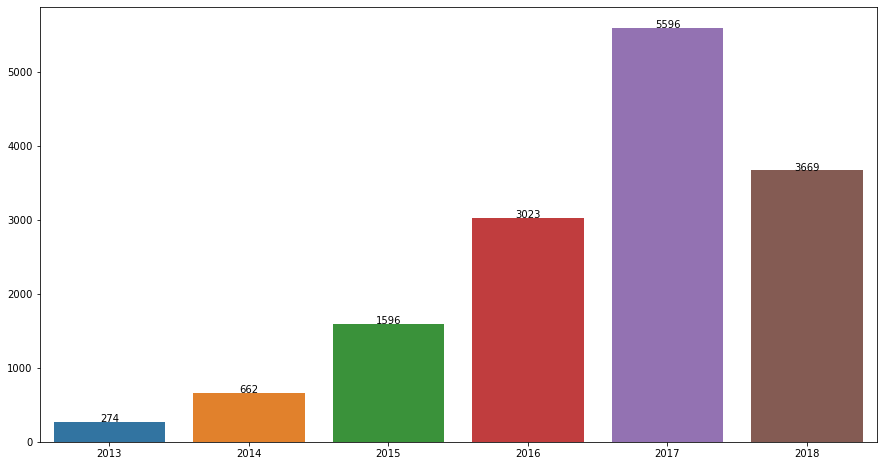

In [109]:
labels=profile['year_joined'].value_counts().index.values.tolist()
values=profile['year_joined'].value_counts().values.tolist()


plt.figure(figsize = (15, 8))
ax = sns.barplot(x=labels, y=values)
labels, values = zip(*sorted(zip(labels, values)))
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")
    
#code_reference : https://stackoverflow.com/questions/55104819/display-count-on-top-of-seaborn-barplot

The Starbucks app has experienced consistent growth of over 100% from 2013 to 2016.In 2017, 6465 customers signed up and created an account in Starbucks  app, an increase of 83.4% over 2016. 2018 saw a dip 35% from 2017 with only 4198 customers creating an account in the app.

In [110]:
final_profile

,customer_id,age,gender,income,year_joined,reward,offer_1_received,offer_1_viewed,offer_2_received,offer_2_viewed,offer_3_received,offer_3_viewed,offer_4_received,offer_4_viewed,offer_5_received,offer_5_viewed,offer_6_received,offer_6_viewed,offer_7_received,offer_7_viewed,offer_8_received,offer_8_viewed,offer_9_received,offer_9_viewed,offer_10_received,offer_10_viewed,offer_1_completed,offer_1_accidentallycompleted,offer_1_ignored,offer_1_didnotcomplete,offer_2_completed,offer_2_accidentallycompleted,offer_2_ignored,offer_2_didnotcomplete,offer_3_completed,offer_3_accidentallycompleted,offer_3_ignored,offer_3_didnotcomplete,offer_4_completed,offer_4_accidentallycompleted,offer_4_ignored,offer_4_didnotcomplete,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete,offer_6_completed,offer_6_accidentallycompleted,offer_6_ignored,offer_6_didnotcomplete,offer_7_completed,offer_7_accidentallycompleted,offer_7_ignored,offer_7_didnotcomplete,offer_8_completed,offer_8_accidentallycompleted,offer_8_ignored,offer_8_didnotcomplete,offer_9_completed,offer_9_accidentallycompleted,offer_9_ignored,offer_9_didnotcomplete,offer_10_completed,offer_10_accidentallycompleted,offer_10_ignored,offer_10_didnotcomplete,amount
0,2,55,F,112000.0,2017,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77.01
1,4,75,F,100000.0,2017,20,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,159.27
2,6,68,M,70000.0,2018,7,0,0,0,0,1,0,1,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,57.73
3,9,65,M,53000.0,2018,19,0,0,0,0,0,0,2,2,0,0,0,0,1,1,0,0,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,36.43
4,13,58,M,51000.0,2017,2,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14815,16996,45,F,54000.0,2018,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,20.03
14816,16997,61,M,72000.0,2018,5,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,25.97
14817,16998,49,M,73000.0,2017,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,39.74
14818,16999,83,F,50000.0,2016,25,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189.67


#### 2. What is the most and least completed offer among all the offers?

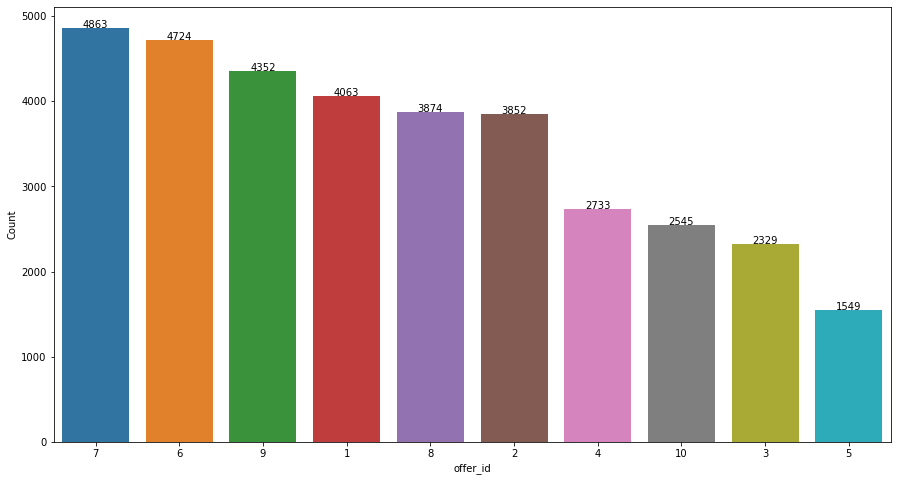

In [111]:
offers_completed_dict={}
for i in range(1,11):
    offers_completed_dict[i]=sum(final_profile['offer_{}_completed'.format(i)])

    
plt.figure(figsize = (15, 8))
offers_completed_df = pd.DataFrame(list(offers_completed_dict.items()))
offers_completed_df.columns =["offer_id", "Count"]


offers_completed_df = offers_completed_df.sort_values('Count',ascending=False).reset_index()

ax=sns.barplot(x='offer_id', y='Count', data=offers_completed_df, order=offers_completed_df['offer_id'])
values=[x for x in offers_completed_dict.values()]
labels=[x for x in offers_completed_dict.keys()]


values, labels= zip(*sorted(zip(values,labels)))
values=list(values)
values.reverse()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")





Offering 7 was the most completed, beating offer 6 by a margin of 181, and is completed 5170 times. Offer 5 was the least completed, with a count of 1567.What accounts for these results?

In [112]:
portfolio[(portfolio['offer_id']==7)| (portfolio['offer_id']==5)].style.hide_index()

offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
5,5,20,240,1,0,0,1,0,0,1
7,2,10,240,1,1,1,1,0,0,1


Offer 7 is a discount type offer which has a difficulty of 10 with 240hr(10 days) duration and a reward of 2.Offer 5 is also a discount type offer which has a difficulty of 20 with 240hr(10 days) duration and a reward of 5.The reward did not lure customers in completing the offer, and an important point to note is that Offer 5 has the highest difficulty.

#### 3. Among all of the offers, which has the most and least accidental completions?

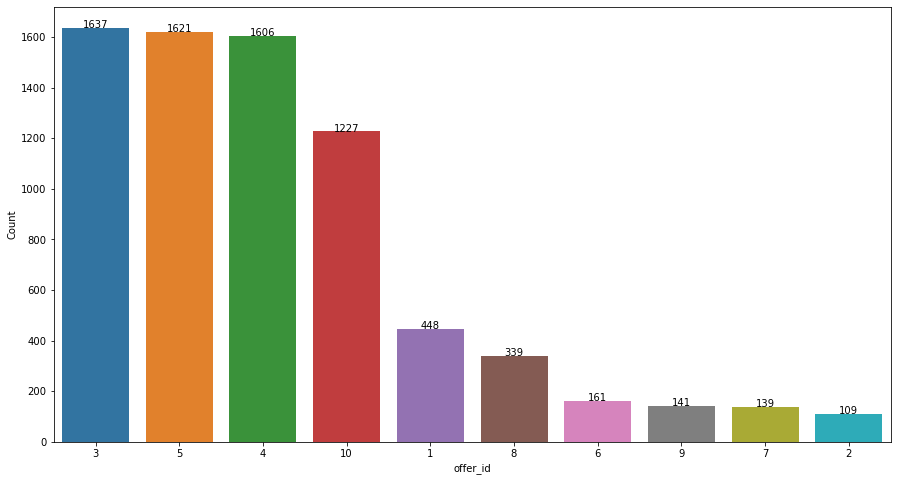

In [113]:
offers_accidentaly_completed_dict={}
for i in range(1,11):
    offers_accidentaly_completed_dict[i]=sum(final_profile['offer_{}_accidentallycompleted'.format(i)])

    
plt.figure(figsize = (15, 8))
offers_accidentaly_completed_df = pd.DataFrame(list(offers_accidentaly_completed_dict.items()))
offers_accidentaly_completed_df.columns =["offer_id", "Count"]


offers_accidentaly_completed_df = offers_accidentaly_completed_df.sort_values('Count',ascending=False).reset_index()

ax=sns.barplot(x='offer_id', y='Count', data=offers_accidentaly_completed_df, order=offers_accidentaly_completed_df['offer_id'])
values=[x for x in offers_accidentaly_completed_dict.values()]
labels=[x for x in offers_accidentaly_completed_dict.keys()]


values, labels= zip(*sorted(zip(values,labels)))
values=list(values)
values.reverse()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")
    

Offer 3 is the most accidentally completed offer and offer 2 is the least accidentally completed offer.Offer 3,4,5 and 10 are completed accidentaly by a large margin when compared to other offers.What must be the reason? Less difficulty?


In [114]:
portfolio[(portfolio['offer_id']==3)| (portfolio['offer_id']==4) | (portfolio['offer_id']==5) | (portfolio['offer_id']==10)].style.hide_index()

offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
3,0,0,96,1,1,0,1,0,1,0
4,5,5,168,1,1,0,1,1,0,0
5,5,20,240,1,0,0,1,0,0,1
10,2,10,168,1,1,0,1,0,0,1


offer 3 is a informational type offer with a difficulty of 0, no wonder it topped the list.Offer 5 has a difficulty so there is a good reason for this to be accidentally completed. Intresting, offer 5 was the least intentionally completed offer but it stands at three in this list. Is the duration of 240 a reason for this? Better to do a seperate analysis on offer 5.offer 10 has a balanced duration time of 168hr and also is the 4th intentionally completed offer.

#### 3. What is the most and least ignored offer among all the offers?

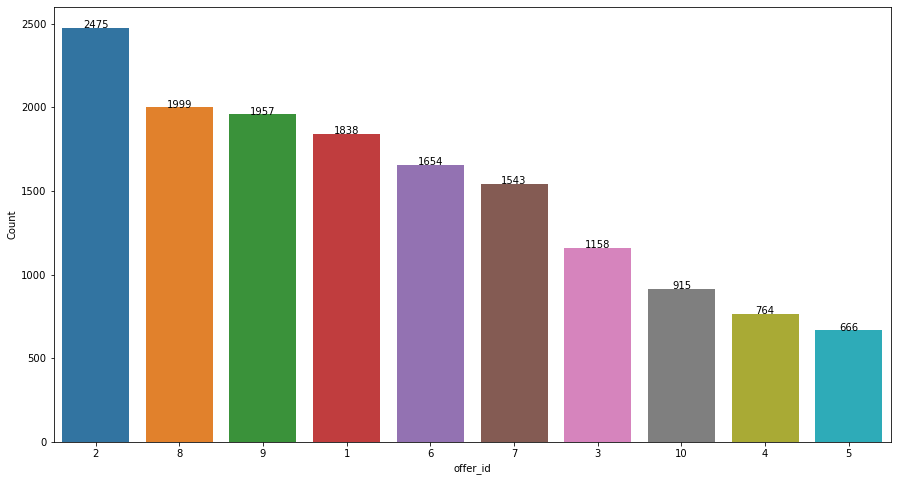

In [115]:
offers_ignored_dict={}
for i in range(1,11):
    offers_ignored_dict[i]=sum(final_profile['offer_{}_ignored'.format(i)])

    
plt.figure(figsize = (15, 8))
offers_ignored_dict_df = pd.DataFrame(list(offers_ignored_dict.items()))
offers_ignored_dict_df.columns =["offer_id", "Count"]


offers_ignored_dict_df  = offers_ignored_dict_df.sort_values('Count',ascending=False).reset_index()

ax=sns.barplot(x='offer_id', y='Count', data=offers_ignored_dict_df , order=offers_ignored_dict_df ['offer_id'])
values=[x for x in offers_ignored_dict.values()]
labels=[x for x in offers_ignored_dict.keys()]


values, labels= zip(*sorted(zip(values,labels)))
values=list(values)
values.reverse()
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")
    

Offer 2 is the most ignored offer and offer 5 is the least ignored offer.

In [116]:
portfolio[(portfolio['offer_id']==2)| (portfolio['offer_id']==5)].style.hide_index()

offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
2,10,10,120,1,1,1,1,1,0,0
5,5,20,240,1,0,0,1,0,0,1


Offer 2 belongs to BOGO(Buy one Get one) offer type.The only reason for this to be topping this is list must be the duration.120hr to complete this offer with a difficulty of 10?.This might fall into coudln't complete category.Offer 5 is the least ignored offer. How can offer 5 be the least ignored offer and third most accidentally completed offer while also being least intentionally completed offer?

#### 4. Offer 5 !
        
    
    

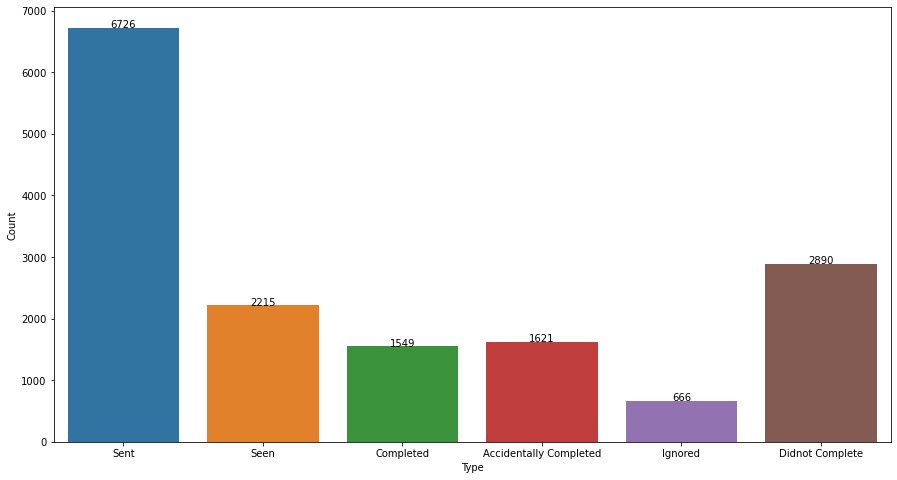

In [117]:
offer_5_sent=sum(offer_5_activity['offer_5_received'])
offer_5_seen=sum(offer_5_activity['offer_5_viewed'])
offer_5_completed=sum(offer_5_activity['offer_5_completed'])
offer_5_accidentallycompleted=sum(offer_5_activity['offer_5_accidentallycompleted'])
offer_5_ignored=sum(offer_5_activity['offer_5_ignored'])
offer_5_didnotcomplete=sum(offer_5_activity['offer_5_didnotcomplete'])

labels=['Sent','Seen','Completed','Accidentally Completed','Ignored','Didnot Complete']
values=[offer_5_sent,offer_5_seen,offer_5_completed,offer_5_accidentallycompleted,offer_5_ignored,offer_5_didnotcomplete]

offer_5_plot_df=pd.DataFrame(list(zip(labels,values)),columns=['Type','Count'])

plt.figure(figsize = (15, 8))
ax=sns.barplot(x='Type', y='Count',data=offer_5_plot_df)

values=list(offer_5_plot_df['Count'])
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")

7668 notifications about the offer 5 were sent out,out of them only 2663 were seen by the users.Is that the reason for the offer 5 to be in least in intentionally completed list and 3rd in  accidentally completed list and again the least one in ignored list.Checking stats about other offer might answer this question.

7668 notifications about the offer were sent out,out of them only 2663 were seen by the users.Is that the reason for the offer 5 to be in least in intentionally completed list and 3rd in  accidentally completed list and again the least one in ignored list. So it is least ignored and 3rd in accidentally completed because it is seen by less users and least in intentionally completed because of the difficulty.

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

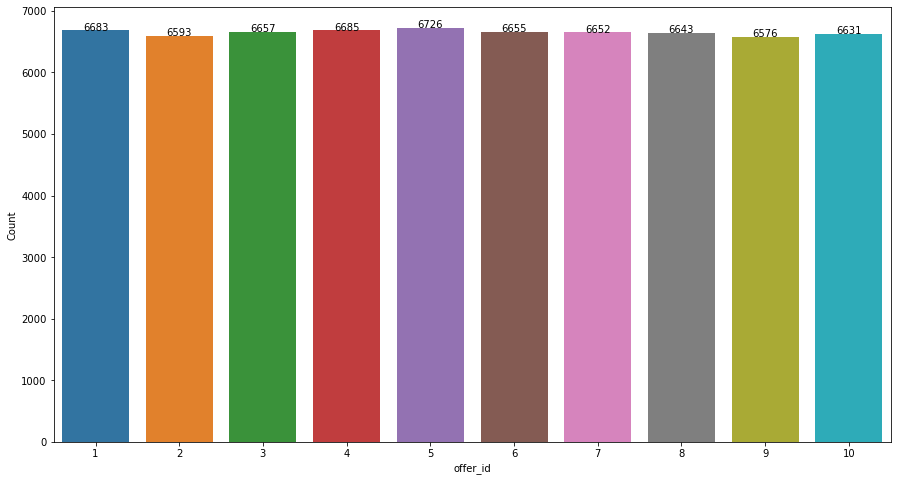

In [118]:
offer_sent_dict={}
for i in range(1,11):
    offer_sent_dict[i]=sum(final_profile['offer_{}_received'.format(i)])
    
    plt.figure(figsize = (15, 8))
offer_sent_dict_df = pd.DataFrame(list(offer_sent_dict.items()))
offer_sent_dict_df.columns =["offer_id", "Count"]

ax=sns.barplot(x='offer_id', y='Count', data=offer_sent_dict_df)
values=[x for x in offer_sent_dict.values()]
labels=[x for x in offer_sent_dict.keys()]

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")
    

So every offer is sent equally.What about the viewed rate?

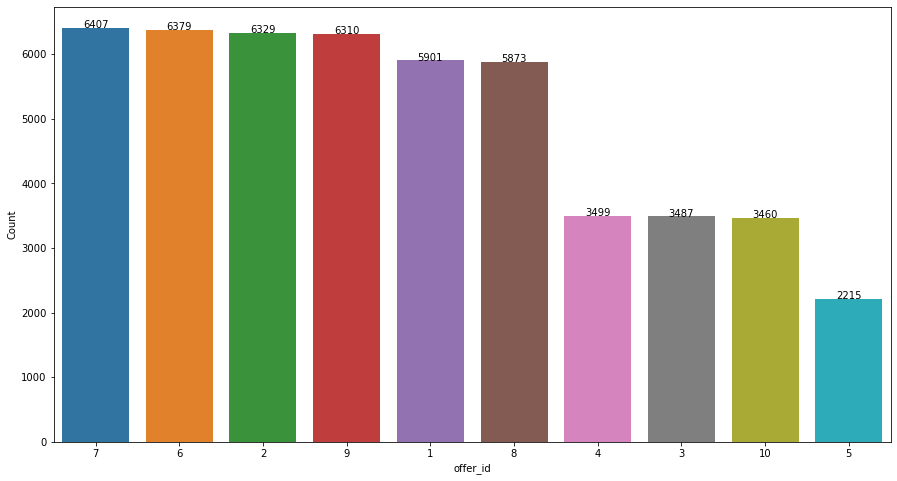

In [119]:
offer_seen_dict={}
for i in range(1,11):
    offer_seen_dict[i]=sum(final_profile['offer_{}_viewed'.format(i)])
    
    
plt.figure(figsize = (15, 8))
offer_seen_dict_df = pd.DataFrame(list(offer_seen_dict.items()))
offer_seen_dict_df.columns =["offer_id", "Count"]

offer_seen_dict_df  = offer_seen_dict_df.sort_values('Count',ascending=False).reset_index()

ax=sns.barplot(x='offer_id', y='Count', data=offer_seen_dict_df,order=offer_seen_dict_df['offer_id'])
values=[x for x in offer_seen_dict.values()]
labels=[x for x in offer_seen_dict.keys()]

values, labels= zip(*sorted(zip(values,labels)))
values=list(values)
values.reverse() 

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,values[i],ha="center")
    
    


Yes!! Offer 5 is the least seen(viewed) offer by the customers.

In [120]:
offer_seen_rate={}
for i in range(1,11):
    offer_seen_rate[i]=(offer_seen_dict[i]/offer_sent_dict[i])*100
offer_seen_rate

{1: 88.29866826275625,
 2: 95.99575307143941,
 3: 52.38095238095239,
 4: 52.341062079281976,
 5: 32.931906036277134,
 6: 95.85274229902329,
 7: 96.31689717378232,
 8: 88.40885142255004,
 9: 95.95498783454988,
 10: 52.17915849796411}

offer 5 has the worst seen rate of only 35%.So it is least in ignored list and 3rd in accidentally completed list because it is seen by less users.The reason for offer 5 being least in intentionally completed must be because of the difficulty.So why do offer 5 has only 35% seen rate?

In [121]:
portfolio.style.hide_index()

offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
1,10,10,168,1,1,1,0,1,0,0
2,10,10,120,1,1,1,1,1,0,0
3,0,0,96,1,1,0,1,0,1,0
4,5,5,168,1,1,0,1,1,0,0
5,5,20,240,1,0,0,1,0,0,1
6,3,7,168,1,1,1,1,0,0,1
7,2,10,240,1,1,1,1,0,0,1
8,0,0,72,1,1,1,0,0,1,0
9,5,5,120,1,1,1,1,1,0,0
10,2,10,168,1,1,0,1,0,0,1


Offer 5 is the only offer that wasn't sent via the mobile app.

# Data Preprocessing

Seperating the customers who intentionally completed the offers.For that the customers must receive the offer first then view it and finally should spent the required amount before the offer duration ends.

In [124]:
for i in range(1,11):
    locals()['offer_{}_sent_ids'.format(i)]=locals()['offer_{}_activity'.format(i)][locals()['offer_{}_activity'.format(i)]['offer_{}_received'.format(i)]==1]['customer_id'].to_list()
    locals()['offer_{}_activity'.format(i)]=locals()['offer_{}_activity'.format(i)][locals()['offer_{}_activity'.format(i)]['offer_{}_received'.format(i)]>=1]
# offer_1_sent_ids=offer_1_activity[offer_1_activity['offer_1_received']==1]['customer_id'].to_list()
# offer_1_activity=offer_1_activity[offer_1_activity['offer_1_received']==1] 

In [125]:
for i in range(1,11):
    locals()['offer_{}_activity'.format(i)].drop({'offer_{}_received'.format(i),'offer_{}_viewed'.format(i),'offer_{}_accidentallycompleted'.format(i),'offer_{}_ignored'.format(i),'offer_{}_didnotcomplete'.format(i)},axis=1,inplace=True)
    locals()['offer_{}_activity'.format(i)].rename({'offer_{}_completed'.format(i):'offer_complete_status'},axis=1,inplace=True)
    

In [126]:
for i in range(1,11):
    locals()['offer_{}_activity'.format(i)]['offer_complete_status']=np.where(locals()['offer_{}_activity'.format(i)]['offer_complete_status']>=1,1,0)

In [128]:
import datetime
profile['years_member']=datetime.datetime.today().year - profile['year_joined']
profile.drop({'year_joined'},axis=1,inplace=True)

In [129]:
profile['income']=profile['income'].astype(int)

In [130]:
profile_offer_1=pd.merge(profile,offer_1_activity,how='inner',on='customer_id')

In [131]:
for i in range(1,11):
    locals()['profile_offer_{}'.format(i)]=pd.merge(profile,locals()['offer_{}_activity'.format(i)],how='inner',on='customer_id')

In [132]:
profile_offer_1

,customer_id,age,gender,income,years_member,offer_complete_status
0,4,75,F,100000,5,1
1,14,61,F,57000,5,1
2,15,26,M,46000,8,1
3,17,49,M,52000,8,1
4,20,61,F,40000,4,0
...,...,...,...,...,...,...
5559,16979,29,F,58000,5,1
5560,16980,63,F,52000,9,1
5561,16985,75,F,78000,6,1
5562,16986,26,M,55000,4,0


In [133]:
filename='data/profile_cleaned.csv'
profile.to_csv(filename,index=False,mode='w+')

In [134]:
for i in range(1,11):
    filename='data/profile_offer_{}.csv'.format(i)
    locals()['profile_offer_{}'.format(i)].to_csv(filename,index=False,mode='w+')
    #locals()['profile_offer_{}'.format(i)] equivalent  profile_offer_

In [135]:
for i in range(1,11):
    locals()['profile_offer_{}'.format(i)]['offer_id']=i

In [136]:
profile_offers_list=[]
for i in range(1,11):
    profile_offers_list.append(locals()['profile_offer_{}'.format(i)])

In [137]:
master_df=pd.concat(profile_offers_list).reset_index(drop=True)

In [138]:
master_df

,customer_id,age,gender,income,years_member,offer_complete_status,offer_id
0,4,75,F,100000,5,1,1
1,14,61,F,57000,5,1,1
2,15,26,M,46000,8,1,1
3,17,49,M,52000,8,1,1
4,20,61,F,40000,4,0,1
...,...,...,...,...,...,...,...
55217,16982,84,M,93000,6,0,10
55218,16985,75,F,78000,6,0,10
55219,16989,64,M,51000,4,0,10
55220,16993,21,F,72000,5,0,10


In [139]:
master_df=master_df.merge(portfolio,on='offer_id',how='outer')

In [140]:
master_df

,customer_id,age,gender,income,years_member,offer_complete_status,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
0,4,75,F,100000,5,1,1,10,10,168,1,1,1,0,1,0,0
1,14,61,F,57000,5,1,1,10,10,168,1,1,1,0,1,0,0
2,15,26,M,46000,8,1,1,10,10,168,1,1,1,0,1,0,0
3,17,49,M,52000,8,1,1,10,10,168,1,1,1,0,1,0,0
4,20,61,F,40000,4,0,1,10,10,168,1,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,16982,84,M,93000,6,0,10,2,10,168,1,1,0,1,0,0,1
55218,16985,75,F,78000,6,0,10,2,10,168,1,1,0,1,0,0,1
55219,16989,64,M,51000,4,0,10,2,10,168,1,1,0,1,0,0,1
55220,16993,21,F,72000,5,0,10,2,10,168,1,1,0,1,0,0,1


In [141]:
master_df.to_csv('data/master_df.csv',index=False,mode='w+')

In [142]:
master_df['age'].max()

101

<AxesSubplot:>

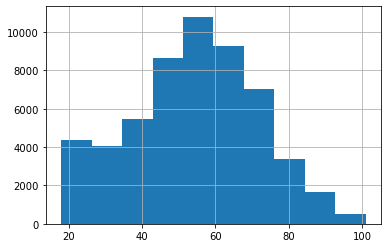

In [143]:
master_df['age'].hist()

Binning the values to handle imbalance in the data set.'jenkspy' library is used to find the natural break points in the values.

In [144]:
# breaks = jenkspy.jenks_breaks(master_df['age'], nb_class=5) 

Using the natural breakpoints custom demographic groups are created.

<AxesSubplot:>

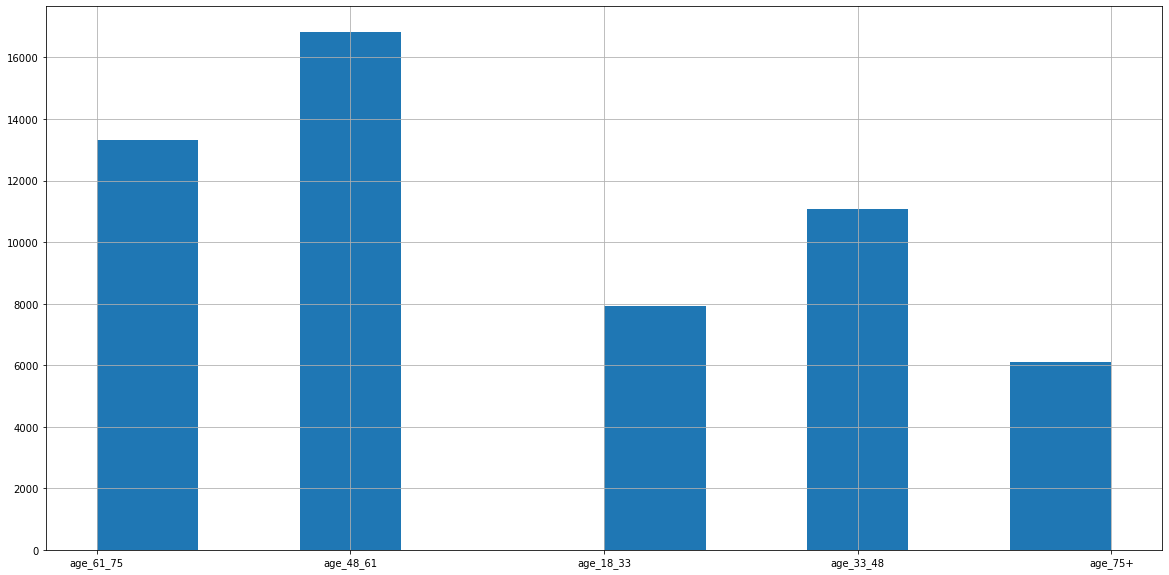

In [145]:
age_breaks=[17.9,33.1,48.1,61.1,75.1,102]
age_labels=['age_18_33','age_33_48','age_48_61','age_61_75','age_75+']
master_df['age_bin'] = pd.cut(master_df['age'] , bins=age_breaks, labels=age_labels, include_lowest=True)
master_df['age_bin'].hist(figsize=(20,10))

<AxesSubplot:>

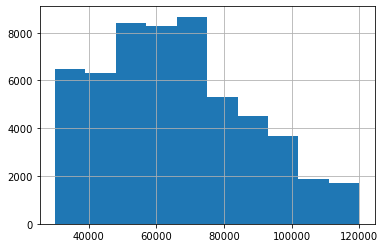

In [146]:
master_df['income'].hist()

<AxesSubplot:>

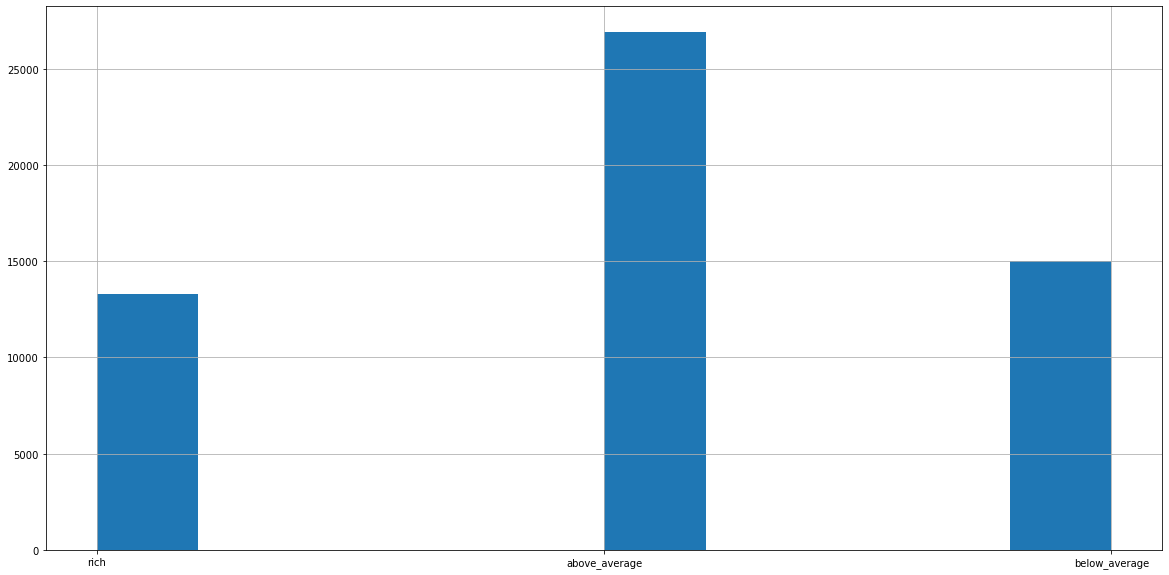

In [147]:
income_breaks=[0,50000.1,80000.1,120000.1]
income_labels=['below_average','above_average','rich']
master_df['income_bin'] = pd.cut(master_df['income'] , bins=income_breaks, labels=income_labels, include_lowest=True)
master_df['income_bin'].hist(figsize=(20,10))

<AxesSubplot:>

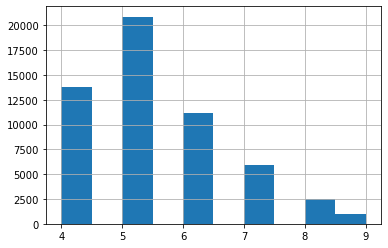

In [148]:
master_df['years_member'].hist()

<AxesSubplot:>

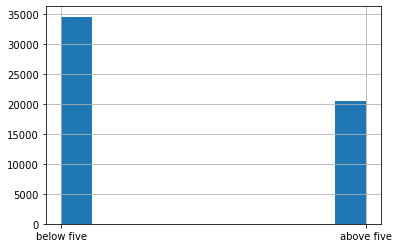

In [149]:
years_member_breaks=[0,5.1,9.1]
years_member_labels=['below five','above five']
master_df['years_member_bin'] = pd.cut(master_df['years_member'] , bins=years_member_breaks, labels=years_member_labels, include_lowest=True)
master_df['years_member_bin'].hist()

<AxesSubplot:>

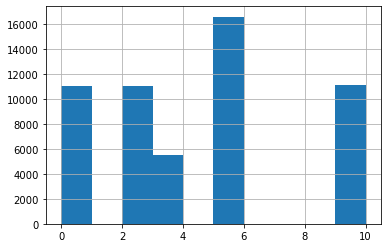

In [150]:
master_df['reward'].hist()

<AxesSubplot:>

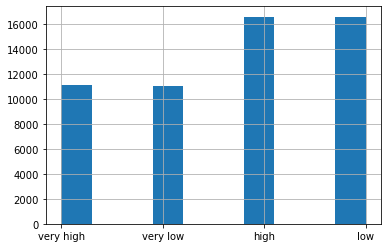

In [151]:
reward_breaks=[0.0,1.9,4.1,6.1,10.1]
reward_labels=['very low','low','high','very high']
master_df['reward_bin'] = pd.cut(master_df['reward'] , bins=reward_breaks, labels=reward_labels, include_lowest=True)
master_df['reward_bin'].hist()

<AxesSubplot:>

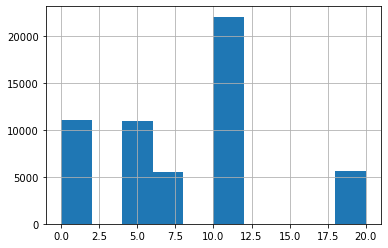

In [152]:
master_df['difficulty'].hist()

<AxesSubplot:>

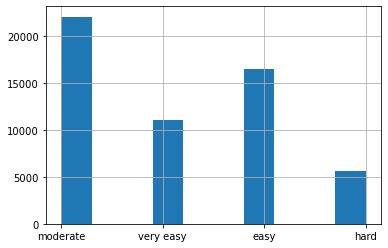

In [153]:
difficulty_breaks=[0.0,4.9,7.1,10.1,20.1]
difficulty_labels=['very easy','easy','moderate','hard']
master_df['difficulty_bin'] = pd.cut(master_df['difficulty'] , bins=difficulty_breaks, labels=difficulty_labels, include_lowest=True)
master_df['difficulty_bin'].hist()

<AxesSubplot:>

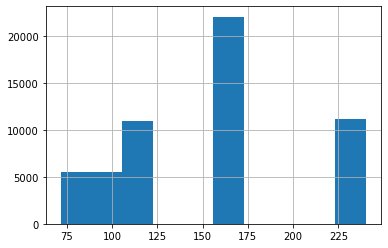

In [154]:
master_df['duration'].hist()

<AxesSubplot:>

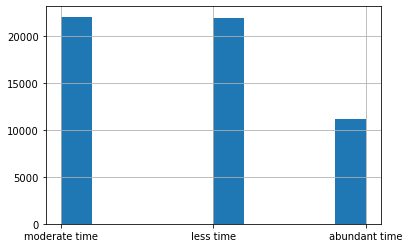

In [155]:
duration_breaks=[70,121,169,241]
duration_labels=['less time','moderate time','abundant time']
master_df['duration_bin'] = pd.cut(master_df['duration'] , bins=duration_breaks, labels=duration_labels, include_lowest=True)
master_df['duration_bin'].hist()

<AxesSubplot:>

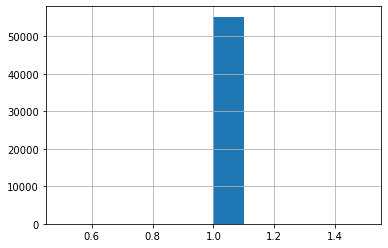

In [156]:
master_df['email'].hist()

Each and every offer is sent via email.

<AxesSubplot:>

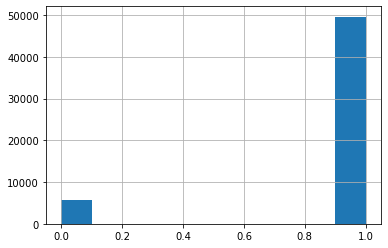

In [158]:
master_df['mobile'].hist()

There are only two possible values so no need of binning.

<AxesSubplot:>

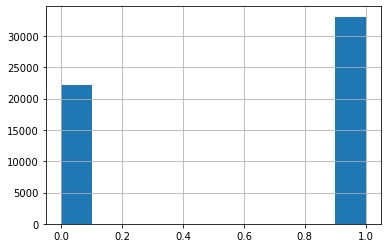

In [159]:
master_df['social'].hist()

<AxesSubplot:>

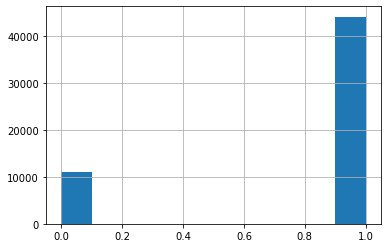

In [160]:
master_df['web'].hist()

In [161]:
#dropping binned columns
master_df.drop({'customer_id','age','income','years_member','offer_id','reward','difficulty','duration'},axis=1,inplace=True)

In [162]:
master_df[['gender','age_bin','income_bin','years_member_bin','reward_bin','difficulty_bin',
           'duration_bin','offer_complete_status','mobile','social','web','bogo','informational','discount']]

,gender,age_bin,income_bin,years_member_bin,reward_bin,difficulty_bin,duration_bin,offer_complete_status,mobile,social,web,bogo,informational,discount
0,F,age_61_75,rich,below five,very high,moderate,moderate time,1,1,1,0,1,0,0
1,F,age_48_61,above_average,below five,very high,moderate,moderate time,1,1,1,0,1,0,0
2,M,age_18_33,below_average,above five,very high,moderate,moderate time,1,1,1,0,1,0,0
3,M,age_48_61,above_average,above five,very high,moderate,moderate time,1,1,1,0,1,0,0
4,F,age_48_61,below_average,below five,very high,moderate,moderate time,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,M,age_75+,rich,above five,low,moderate,moderate time,0,1,0,1,0,0,1
55218,F,age_61_75,above_average,above five,low,moderate,moderate time,0,1,0,1,0,0,1
55219,M,age_61_75,above_average,below five,low,moderate,moderate time,0,1,0,1,0,0,1
55220,F,age_18_33,above_average,below five,low,moderate,moderate time,0,1,0,1,0,0,1


# Modeling

In [187]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import f1_score,confusion_matrix, classification_report,accuracy_score
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [164]:
labelencoder = LabelEncoder()
d = defaultdict(LabelEncoder)
master_df_ml=master_df.apply(lambda x: d[x.name].fit_transform(x))

In [165]:
X=master_df_ml[['gender','age_bin','income_bin','years_member_bin','reward_bin','difficulty_bin','duration_bin',
             'mobile','social','web','email','bogo','informational','discount']]
y=master_df_ml['offer_complete_status']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [170]:
#to display accuracy scores of models on train and test
def train_predict_result(model, X_train, y_train, X_test, y_test):
    results = {}
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    results['acc_train'] = accuracy_score(y_train, y_pred_train) #Accuracy of training
    results['acc_test'] = accuracy_score(y_test, y_pred_test) #Accuracy of testing
    
    results['f1_train'] = f1_score(y_train, y_pred_train) #f1-score for training
    results['f1_test'] = f1_score(y_test, y_pred_test) #f1-score for testing
    
    print("{} trained.".format(model.__class__.__name__))
    return results

In [171]:
gnb = GaussianNB()
svm=SVC(kernel="linear",C=0.025,random_state=0)
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=600,random_state=0)
knn=KNeighborsClassifier()
dectree = DecisionTreeClassifier(random_state=0)
rfc = RandomForestClassifier(random_state=0)

models = [gnb,svm, logreg,knn, dectree, rfc]

In [172]:
result_dict = {}
for model in models:
    model_name = model.__class__.__name__
    result_dict[model_name] = train_predict_result(model, X_train, y_train, X_test, y_test)

GaussianNB trained.
SVC trained.
LogisticRegression trained.
KNeighborsClassifier trained.
DecisionTreeClassifier trained.
RandomForestClassifier trained.


In [173]:
for mod in range(len(models)):
    print(models[mod].__class__.__name__, ":")
    display(pd.DataFrame(result_dict[models[mod].__class__.__name__], index = range(1)))
    print('===================================\n\n')

GaussianNB :


,acc_train,acc_test,f1_train,f1_test
0,0.65765,0.654957,0.728259,0.72438




SVC :


,acc_train,acc_test,f1_train,f1_test
0,0.655635,0.65215,0.70136,0.697242




LogisticRegression :


,acc_train,acc_test,f1_train,f1_test
0,0.65731,0.658035,0.68931,0.688392




KNeighborsClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.65147,0.649163,0.689633,0.686919




DecisionTreeClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.688594,0.672612,0.723283,0.708434




RandomForestClassifier :


,acc_train,acc_test,f1_train,f1_test
0,0.688594,0.673246,0.723827,0.70949


### reason to why we chose RandomForest 

In [174]:
#Checking precision and recall
labels=np.unique(y_train)
y_pred=rfc.predict(X_test)
print(classification_report(y_test, y_pred, labels = labels))
print("f1 Score",f1_score(y_test, y_pred))
print("Labels:", labels)
print("Confusion Matrix:\n", confusion_matrix(y_test.values, y_pred, labels = labels))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      4958
           1       0.70      0.72      0.71      6087

    accuracy                           0.67     11045
   macro avg       0.67      0.67      0.67     11045
weighted avg       0.67      0.67      0.67     11045

f1 Score 0.709490461241246
Labels: [0 1]
Confusion Matrix:
 [[3029 1929]
 [1680 4407]]


<AxesSubplot:>

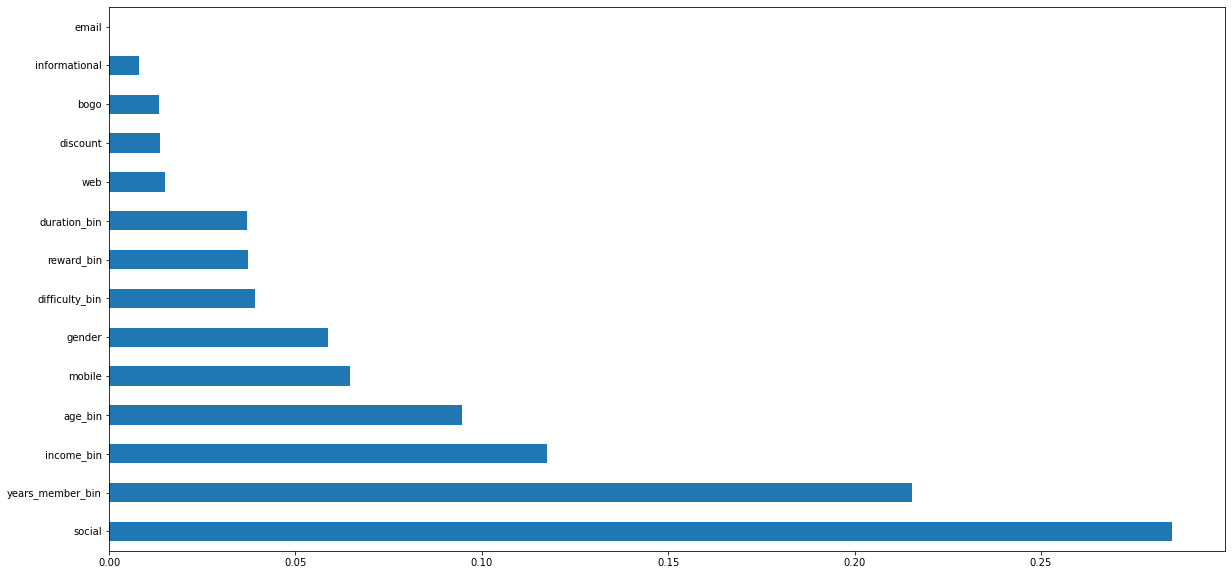

In [176]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',figsize=(20,10))

In [179]:
feat_importances

gender              0.058829
age_bin             0.094818
income_bin          0.117594
years_member_bin    0.215427
reward_bin          0.037342
difficulty_bin      0.039019
duration_bin        0.036878
mobile              0.064742
social              0.285164
web                 0.014886
email               0.000000
bogo                0.013519
informational       0.008066
discount            0.013716
dtype: float64

email has 0 importance removing 'email' and training the model again

In [180]:
def train_n_results(model,X_train,y_train,X_test):
    model.fit(X_train, y_train)
    y_train_pred=model.predict(X_train)
    labels=np.unique(y_train)
    print("Accuracy on train", accuracy_score(y_train, y_train_pred))
    print("Classification report on train\n", classification_report(y_train, y_train_pred, labels = labels))
    print("=================================================================")
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred, labels = labels))
    print("f1 Score",f1_score(y_test, y_pred))
    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_matrix(y_test.values, y_pred, labels = labels))
    return model,y_pred

In [181]:
rfc = RandomForestClassifier(random_state=0)
X=master_df_ml[['gender','age_bin','income_bin','years_member_bin','reward_bin','difficulty_bin','duration_bin',
             'mobile','social','web','bogo','informational','discount']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
model,y_pred=train_n_results(rfc,X_train,y_train,X_test)

Accuracy on train 0.6885936120605745
Classification report on train
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     19721
           1       0.71      0.74      0.72     24456

    accuracy                           0.69     44177
   macro avg       0.68      0.68      0.68     44177
weighted avg       0.69      0.69      0.69     44177

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      4958
           1       0.70      0.72      0.71      6087

    accuracy                           0.67     11045
   macro avg       0.67      0.67      0.67     11045
weighted avg       0.67      0.67      0.67     11045

f1 Score 0.7092826664519766
Labels: [0 1]
Confusion Matrix:
 [[3029 1929]
 [1682 4405]]


# GridSearchCV to find the best parameters.

In [182]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [183]:
n_estimators = [100,200,300,400,500]

min_samples_split = [25,50,75,100]

max_depth = [7,9,11,13,15,17,19]

bootstrap = [True, False]

criterion=['gini','entropy']

parameters = {'n_estimators': n_estimators,
              'min_samples_split':min_samples_split,
               'max_depth': max_depth,
               'bootstrap': bootstrap,
              'criterion':criterion
             }

In [227]:
#takes upto 34 minutes on a 6 threaded processor,'{'bootstrap': False,
# 'criterion': 'gini','max_depth': 17,'min_samples_split': 25,'n_estimators': 100}' are the best_params
import time
start = time.time()
cv = KFold(n_splits=5, shuffle=True, random_state=1)

rfc_grid = GridSearchCV(estimator=rfc,
                    param_grid=parameters,
                    scoring='precision',
                    cv = cv,
                    verbose=10,
                    n_jobs=-1)
rfc_grid.fit(X_train,y_train)
end = time.time()
print("Time taken to perform GridSerach",(end - start)/60)

Fitting 5 folds for each of 560 candidates, totalling 2800 fits
Time taken to perform GridSerach 34.061728886763255


In [228]:
rfc_grid.best_score_

0.7004570920949408

In [230]:
best_params = rfc_grid.best_params_
best_params

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 17,
 'min_samples_split': 25,
 'n_estimators': 100}

In [231]:
rfc_best=RandomForestClassifier(n_estimators=100,criterion='gini',bootstrap=False,max_depth=17,min_samples_split=25,random_state=0)

In [232]:
model,y_pred=train_n_results(rfc_best,X_train,y_train,X_test)

Accuracy on train 0.6882767050727754
Classification report on train
               precision    recall  f1-score   support

           0       0.66      0.63      0.64     19721
           1       0.71      0.74      0.72     24456

    accuracy                           0.69     44177
   macro avg       0.68      0.68      0.68     44177
weighted avg       0.69      0.69      0.69     44177

              precision    recall  f1-score   support

           0       0.64      0.61      0.63      4958
           1       0.70      0.72      0.71      6087

    accuracy                           0.67     11045
   macro avg       0.67      0.67      0.67     11045
weighted avg       0.67      0.67      0.67     11045

f1 Score 0.709490461241246
Labels: [0 1]
Confusion Matrix:
 [[3029 1929]
 [1680 4407]]


write something about decrease in false negatives

<AxesSubplot:>

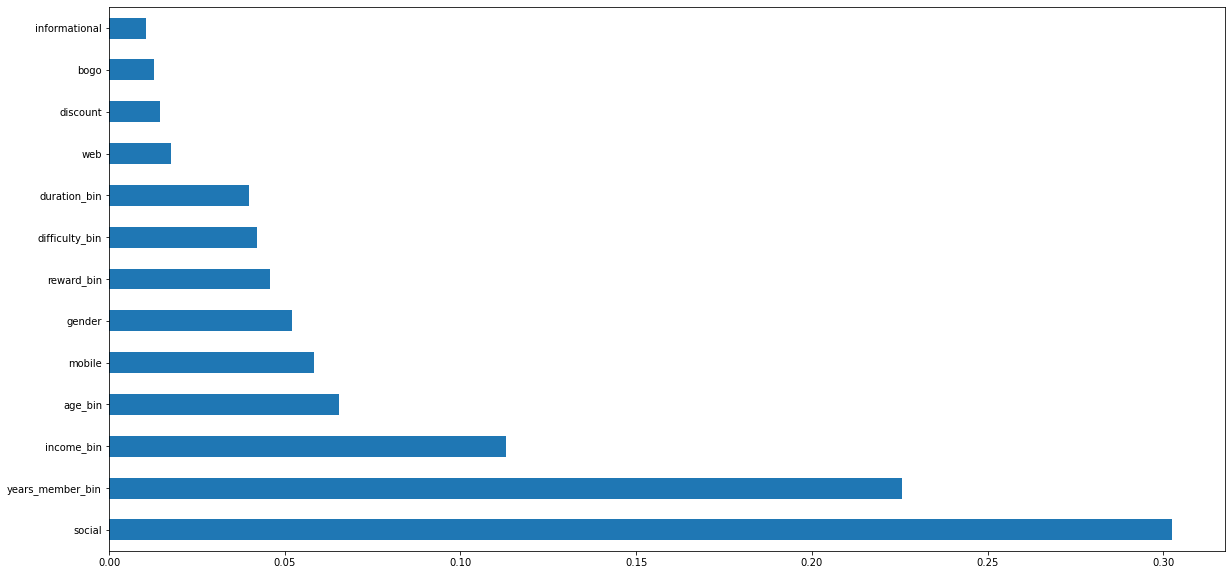

In [233]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh',figsize=(20,10))

In [234]:
import pickle
filename='models/{}'.format(model.__class__.__name__)
pickle.dump(model, open(filename, 'wb'))

In [235]:
test_data=pd.read_csv('data/Starbucks_X_test.csv')

In [236]:
test_data

,Gender,Age range,Income range,Member ship
0,Male,18-33,30k-50k,<=5 years
1,Male,33-48,30k-50k,<=5 years
2,Male,48-61,30k-50k,<=5 years
3,Male,61-75,30k-50k,<=5 years
4,Male,75+,30k-50k,<=5 years
...,...,...,...,...
85,Others,18-33,80k+,>5 years
86,Others,33-48,80k+,>5 years
87,Others,48-61,80k+,>5 years
88,Others,61-75,80k+,>5 years


In [237]:
age_range_dict={'18-33':'age_18_33','33-48':'age_33_48','48-61':'age_48_61','61-75':'age_61_75','75+':'age_75+'}
gender_dict={'Male':'M','Female':'F','Others':'O'}
income_dict={'30k-50k':'below_average','50k-80k':'above_average','80k+':'rich'}
membership_dict={'<=5 years':'below five','>5 years':'above five'}

In [238]:
test_data['Age range']=test_data['Age range'].map(age_range_dict)
test_data['Gender']=test_data['Gender'].map(gender_dict)
test_data['Income range']=test_data['Income range'].map(income_dict)
test_data['Member ship']=test_data['Member ship'].map(membership_dict)

In [239]:
test_data.head(3)

,Gender,Age range,Income range,Member ship
0,M,age_18_33,below_average,below five
1,M,age_33_48,below_average,below five
2,M,age_48_61,below_average,below five


In [240]:
#renaming the columns to perform label encoding 
test_data.rename({'Age range':'age_bin','Gender':'gender','Income range':'income_bin','Member ship':'years_member_bin',},axis=1,inplace=True)

In [241]:
test_data=test_data.apply(lambda x: d[x.name].transform(x))

In [242]:
portfolio_ml=portfolio.copy()

portfolio_ml['reward_bin'] = pd.cut(portfolio_ml['reward'] , bins=reward_breaks, labels=reward_labels, include_lowest=True)

portfolio_ml['difficulty_bin'] = pd.cut(portfolio_ml['difficulty'] , bins=difficulty_breaks, labels=difficulty_labels, include_lowest=True)


portfolio_ml['duration_bin'] = pd.cut(portfolio_ml['duration'] , bins=duration_breaks, labels=duration_labels, include_lowest=True)

portfolio_ml.drop({'offer_id','reward','difficulty','duration'},axis=1,inplace=True)

In [243]:
portfolio_ml=portfolio_ml.apply(lambda x: d[x.name].transform(x))

In [244]:
#rearranging the columns according to the train data set's order whith which the model is trained
portfolio_ml=portfolio_ml[['reward_bin','difficulty_bin','duration_bin',
             'mobile','social','web','bogo','informational','discount']]
portfolio_ml

,reward_bin,difficulty_bin,duration_bin,mobile,social,web,bogo,informational,discount
0,2,2,2,1,1,0,1,0,0
1,2,2,1,1,1,1,1,0,0
2,3,3,1,1,0,1,0,1,0
3,0,0,2,1,0,1,1,0,0
4,0,1,0,0,0,1,0,0,1
5,1,0,2,1,1,1,0,0,1
6,1,2,0,1,1,1,0,0,1
7,3,3,1,1,1,0,0,1,0
8,0,0,1,1,1,1,1,0,0
9,1,2,2,1,0,1,0,0,1


In [245]:
test_data_ml=test_data[['gender','age_bin','income_bin','years_member_bin']].copy()

In [246]:
model.predict_proba(pd.DataFrame([[1,0,1,1,3,3,1,1,1,0,0,1,0]]))[0] #offer 1
#['gender','age_bin','income_bin','years_member_bin','reward_bin','difficulty_bin','duration_bin',
#            'mobile','social','web','bogo','informational','discount']

array([0.31012658, 0.68987342])

In [247]:
model.predict_proba(pd.DataFrame([[1,0,1,1,3,3,1,1,1,0,0,1,0]]))[0][1] #offer 1  #to pluck the probability

0.6898734177215197

In [248]:
#changing dataframe index to start from one
portfolio_ml.index = np.arange(1, len(portfolio_ml)+1)
test_data_ml.index = np.arange(1, len(test_data_ml)+1)

In [249]:
for (test_data_index,gender,age_bin,income_bin,years_member_bin) in test_data_ml.itertuples():
    max_prob_of_offer=0.0
    max_prob_offer=None
    for (portfolio_index,reward_bin,difficulty_bin,duration_bin,mobile,social,web,bogo,informational,discount) in portfolio_ml.itertuples():
        current_offer_prob=model.predict_proba(pd.DataFrame([[gender,age_bin,income_bin,years_member_bin,reward_bin,difficulty_bin,duration_bin,mobile,social,web,bogo,informational,discount]]))[0][1]
        if current_offer_prob>max_prob_of_offer:
            max_prob_of_offer=current_offer_prob
            max_prob_offer=portfolio_index
    #print("The maximum probability among all the offers is {} for the offer {} for the demograhic with the id {}".format(max_prob_of_offer,max_prob_offer,test_data_index))
    #print("=====================================================================================")
    #test_data['max_prob_offer']=max_prob_offer
    #test_data['max_prob_of_offer']=max_prob_of_offer
    test_data_ml.at[test_data_index, 'max_prob_offer']=int(max_prob_offer)
    test_data_ml.at[test_data_index, 'max_prob_of_offer']=float("{0:.2f}".format(max_prob_of_offer))

In [250]:
test_data_ml['max_prob_offer']=test_data_ml['max_prob_offer'].astype(int)
test_data_ml

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
1,1,0,1,1,8,0.69
2,1,1,1,1,8,0.68
3,1,2,1,1,8,0.66
4,1,3,1,1,8,0.69
5,1,4,1,1,8,0.76
...,...,...,...,...,...,...
86,2,0,2,0,9,0.93
87,2,1,2,0,2,0.97
88,2,2,2,0,2,0.95
89,2,3,2,0,7,0.94


In [251]:
#inverse transforming the labelled data to original form
test_data_ml[['gender','age_bin','income_bin','years_member_bin']]=test_data_ml[['gender',
                                                                                 'age_bin','income_bin','years_member_bin']].apply(lambda x: d[x.name].inverse_transform(x))
test_data_ml

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
1,M,age_18_33,below_average,below five,8,0.69
2,M,age_33_48,below_average,below five,8,0.68
3,M,age_48_61,below_average,below five,8,0.66
4,M,age_61_75,below_average,below five,8,0.69
5,M,age_75+,below_average,below five,8,0.76
...,...,...,...,...,...,...
86,O,age_18_33,rich,above five,9,0.93
87,O,age_33_48,rich,above five,2,0.97
88,O,age_48_61,rich,above five,2,0.95
89,O,age_61_75,rich,above five,7,0.94


In [252]:
#swapping keys and values to remap the data to redable format
age_range_dict_remap = {y:x for x,y in age_range_dict.items()}
gender_dict_remap = {y:x for x,y in gender_dict.items()}
income_dict_remap = {y:x for x,y in income_dict.items()}
membership_dict_remap = {y:x for x,y in membership_dict.items()}
test_data_ml['age_bin']=test_data_ml['age_bin'].map(age_range_dict_remap)
test_data_ml['gender']=test_data_ml['gender'].map(gender_dict_remap)
test_data_ml['income_bin']=test_data_ml['income_bin'].map(income_dict_remap)
test_data_ml['years_member_bin']=test_data_ml['years_member_bin'].map(membership_dict_remap)

<AxesSubplot:>

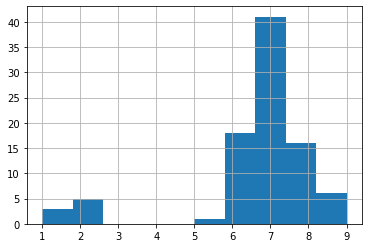

In [253]:
test_data_ml['max_prob_offer'].hist()

In [254]:
test_data_ml

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
1,Male,18-33,30k-50k,<=5 years,8,0.69
2,Male,33-48,30k-50k,<=5 years,8,0.68
3,Male,48-61,30k-50k,<=5 years,8,0.66
4,Male,61-75,30k-50k,<=5 years,8,0.69
5,Male,75+,30k-50k,<=5 years,8,0.76
...,...,...,...,...,...,...
86,Others,18-33,80k+,>5 years,9,0.93
87,Others,33-48,80k+,>5 years,2,0.97
88,Others,48-61,80k+,>5 years,2,0.95
89,Others,61-75,80k+,>5 years,7,0.94


In [255]:
test_data_ml.to_csv('data/final_results.csv',index=False,mode='w+')

Seperating offers based on the type(BOGO,Informational and Discount)

In [256]:
portfolio

,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,informational,discount
0,1,10,10,168,1,1,1,0,1,0,0
1,2,10,10,120,1,1,1,1,1,0,0
2,3,0,0,96,1,1,0,1,0,1,0
3,4,5,5,168,1,1,0,1,1,0,0
4,5,5,20,240,1,0,0,1,0,0,1
5,6,3,7,168,1,1,1,1,0,0,1
6,7,2,10,240,1,1,1,1,0,0,1
7,8,0,0,72,1,1,1,0,0,1,0
8,9,5,5,120,1,1,1,1,1,0,0
9,10,2,10,168,1,1,0,1,0,0,1


In [257]:
bogo=[1,2,4,9]
test_data_ml[test_data_ml['max_prob_offer'].isin(bogo)] #bogo

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
12,Others,33-48,30k-50k,<=5 years,9,0.75
21,Female,18-33,50k-80k,<=5 years,9,0.74
29,Others,61-75,50k-80k,<=5 years,2,0.75
41,Others,18-33,80k+,<=5 years,1,0.70
42,Others,33-48,80k+,<=5 years,2,0.90
43,Others,48-61,80k+,<=5 years,2,0.91
48,Male,48-61,30k-50k,>5 years,9,0.86
52,Female,33-48,30k-50k,>5 years,1,1.00
57,Others,33-48,30k-50k,>5 years,1,0.93
62,Male,33-48,50k-80k,>5 years,9,0.95


In [258]:
informational=[3,8]
test_data_ml[test_data_ml['max_prob_offer'].isin(informational)] #informational

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
1,Male,18-33,30k-50k,<=5 years,8,0.69
2,Male,33-48,30k-50k,<=5 years,8,0.68
3,Male,48-61,30k-50k,<=5 years,8,0.66
4,Male,61-75,30k-50k,<=5 years,8,0.69
5,Male,75+,30k-50k,<=5 years,8,0.76
8,Female,48-61,30k-50k,<=5 years,8,0.74
9,Female,61-75,30k-50k,<=5 years,8,0.84
10,Female,75+,30k-50k,<=5 years,8,0.87
13,Others,48-61,30k-50k,<=5 years,8,0.72
14,Others,61-75,30k-50k,<=5 years,8,0.83


In [259]:
discount=[5,6,7,10]
test_data_ml[test_data_ml['max_prob_offer'].isin(discount)] #discount

,gender,age_bin,income_bin,years_member_bin,max_prob_offer,max_prob_of_offer
6,Female,18-33,30k-50k,<=5 years,6,0.75
7,Female,33-48,30k-50k,<=5 years,6,0.69
11,Others,18-33,30k-50k,<=5 years,7,0.78
17,Male,33-48,50k-80k,<=5 years,6,0.62
18,Male,48-61,50k-80k,<=5 years,7,0.67
20,Male,75+,50k-80k,<=5 years,7,0.68
22,Female,33-48,50k-80k,<=5 years,7,0.74
23,Female,48-61,50k-80k,<=5 years,6,0.78
24,Female,61-75,50k-80k,<=5 years,7,0.70
25,Female,75+,50k-80k,<=5 years,6,0.78


In [260]:
print("No of BOGO offers recommended :{}".format(test_data_ml[test_data_ml['max_prob_offer'].isin(bogo)].shape[0]))
print("No of Informational offers recommended :{}".format(test_data_ml[test_data_ml['max_prob_offer'].isin(informational)].shape[0]))
print("No of Discount offers recommended :{}".format(test_data_ml[test_data_ml['max_prob_offer'].isin(discount)].shape[0]))

No of BOGO offers recommended :14
No of Informational offers recommended :16
No of Discount offers recommended :60
